# Analysis Dataset

In [1]:
import os
import requests
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
path = ".."

training_folder = 'D:/Dataset/aidea-farmland-crops-autumn/train'

public_folder = 'D:/Dataset/aidea-farmland-crops-autumn/public'

labels = next(os.walk(training_folder), (None, None, []))[1]

## Helper Functions

In [3]:
# Note: PIL will automatically correct the width and height according to EXIF (angle)
def get_image_information_without_loading(path, limit=None, verbose=0):
    files, folders = [], []
    data = {key: [] for key in ['file', 'label', 'shape', 'height', 'width', 'taken_datetime', 'make', 'model', 'angle']}
    for (dirpath, foldernames, filenames) in os.walk(path):
        folders.extend(foldernames), files.extend(filenames)
        break
    for idx, folder in enumerate(folders):
        folderdir = F'{path}/{folder}'
        if(verbose):
            print(F'{idx+1}/{len(folders)}, folderdir: {folderdir}')
        for file in os.listdir(folderdir)[:limit]:
            filedir = F'{path}/{folder}/{file}'
            image = Image.open(filedir)
            data['file'].append(file)
            data['label'].append(folder)
            data['shape'].append(image.size)
            data['width'].append(image.size[0])
            data['height'].append(image.size[1])
            # check image._getexif is not NoneType and has key 36867
            data['taken_datetime'].append(pd.to_datetime(image._getexif()[36867], format="%Y:%m:%d %H:%M:%S") if 
                (image._getexif() is not None and 36867 in image._getexif()) else None)
            # check image._getexif is not NoneType and has key 271
            data['make'].append(image._getexif()[271] if 
                (image._getexif() is not None and 271 in image._getexif()) else None)
            # check image._getexif is not NoneType and has key 272
            data['model'].append(image._getexif()[272] if 
                (image._getexif() is not None and 272 in image._getexif()) else None)
            # check image._getexif is not NoneType and has key 274
            data['angle'].append(image._getexif()[274] if (image._getexif() is not None and 274 in image._getexif()) else None)
    return pd.DataFrame(data)

In [4]:
def get_angle_from_exif(path):
    image = Image.open(path)
    angle = image._getexif()[274] if (image._getexif() is not None and 274 in image._getexif()) else None
    return angle 

## Read Image and EXIF
讀取圖片的基本資料，需要注意並非每張圖片都有 EXIF 資訊

In [ ]:
data = get_image_information_without_loading(training_folder, verbose=1)
# Get Datetime from EXIF
data['taken_month'] = pd.to_datetime(data['taken_datetime']).dt.month
data['taken_year'] = pd.to_datetime(data['taken_datetime']).dt.year
data['taken_hour'] = pd.to_datetime(data['taken_datetime']).dt.hour
# Get Angle from EXIF
data['angle'] = data['angle'].apply(lambda x: {1:0, 3:180, 6:270, 8:90}[x] if x in [1, 3, 6, 8] else x)
data.to_csv(F'{path}/train_tag_loc_coor_describe.csv', index=False)

In [5]:
data = pd.read_csv(F'{path}/data/train_tag_loc_coor_describe.csv')
data.describe()

,taken_month,taken_year,taken_hour,target_fid,target_x,target_y,town_x,town_y,width,height,angle
count,55096.000000,55096.000000,55096.000000,89514.000000,89514.000000,89514.000000,89514.000000,89514.000000,89514.000000,89514.000000,84356.000000
mean,7.317174,2019.442428,12.252940,44756.500000,0.650770,-33.431352,120.563448,23.622252,2783.064236,3355.647094,75.447390
std,3.112334,0.550250,3.143825,25840.610335,22.651154,92.331170,0.289508,0.576954,1026.272960,1464.427506,121.155522
min,1.000000,2019.000000,4.000000,0.000000,-1462.000000,-2683.000000,120.099205,22.049339,750.000000,640.000000,0.000000
25%,4.000000,2019.000000,10.000000,22378.250000,0.000000,0.000000,120.364716,23.404182,1633.000000,1600.000000,0.000000
50%,9.000000,2019.000000,12.000000,44756.500000,0.000000,0.000000,120.483185,23.778591,3000.000000,4000.000000,0.000000
75%,10.000000,2020.000000,15.000000,67134.750000,0.000000,0.000000,120.665039,23.955526,3120.000000,4208.000000,270.000000
max,12.000000,2022.000000,20.000000,89513.000000,1004.000000,2043.000000,121.760269,25.083782,8000.000000,8000.000000,270.000000


In [7]:
# Check how much data has exif
invalid_takens = data[(data['taken_datetime'].isnull())]
print(F'Invalid Takens: {len(invalid_takens)} ({len(invalid_takens)/len(data)*100:.2f}%)')

Invalid Takens: 34418 (38.45%)


## Get Elevation of Towns
取得各個鄉鎮的海拔資訊

In [9]:
# Script for returning elevation from lat, long, based on open elevation data, which in turn is based on SRTM
def get_elevation(lat, long):
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query).json()  # json object, various ways you can extract value
    # one approach is to use pandas json functionality:
    elevation = pd.json_normalize(r, 'results')['elevation'].values[0]
    return elevation

In [47]:
group_by_town_x_y = data.groupby(['county_name', 'town_name', 'town_x', 'town_y']).size().reset_index(name='counts')
group_by_town_x_y = group_by_town_x_y.sort_values(by=['counts'], inplace=False).reset_index(drop=True)
len(group_by_town_x_y)

211

In [55]:
group_by_town_x_y['town_z'] = group_by_town_x_y.apply(lambda row: get_elevation(row['town_y'], row['town_x']), axis=1)
group_by_town_x_y.to_csv(F'{path}/data/train_groupby_town_elevation.csv', index=None)

## Apply Elevation to Dataset
將海拔資訊加入到資料集中

In [10]:
def get_elevation_from_dataframe_by_county_town(df, county_name, town_name):
    df = df[df['county_name'].eq(county_name)]
    df = df[df['town_name'].eq(town_name)]
    return df['town_z'].mean()

In [12]:
group_by_town_x_y = pd.read_csv(F'{path}/data/train_groupby_town_elevation.csv')

In [59]:
data['town_z'] = data.apply(lambda row: get_elevation_from_dataframe_by_county_town(group_by_town_x_y, row['county_name'], row['town_name']), axis=1)
data.to_csv(F'{path}/data/train_tag_loc_coor_describe_elevation.csv', index=None)

## View counts of Labels
檢視類別的分布

In [ ]:
group_by_label = data.groupby(['label']).size().reset_index(name='counts')
group_by_label = group_by_label.sort_values(by=['counts'], inplace=False)
group_by_label.head(3)

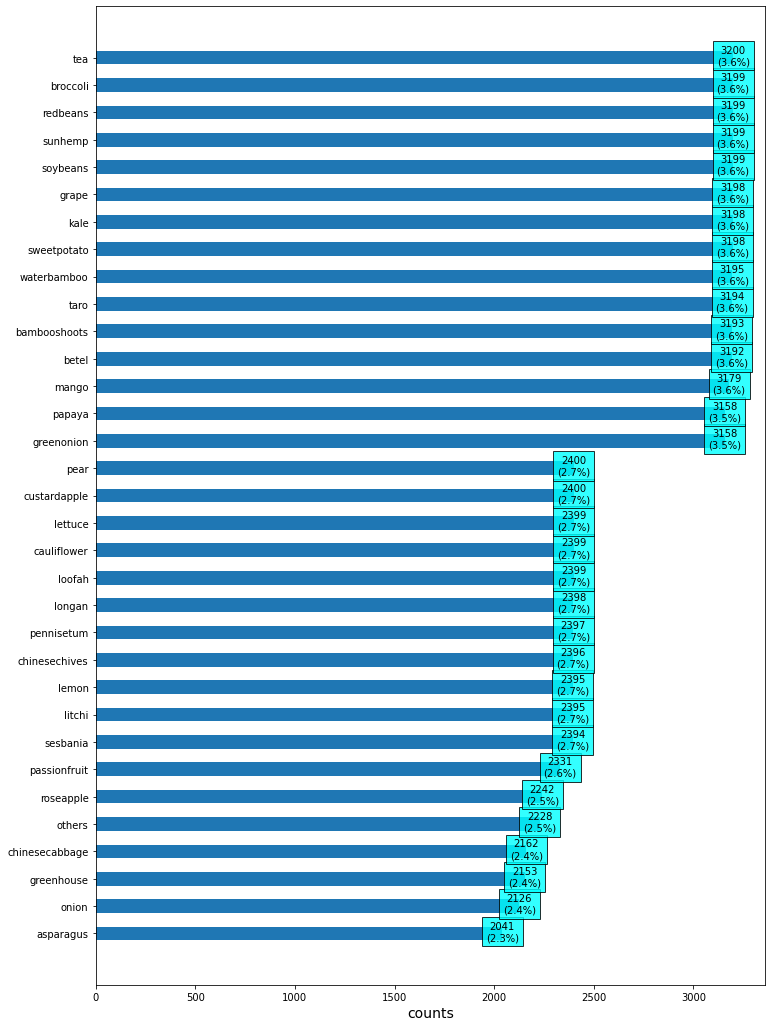

In [45]:
plt.figure(figsize=(12, 18))
# set data to plt.
plt.barh(group_by_label['label'].tolist(),
    group_by_label['counts'].tolist(), 
    height=0.5, 
    align='center')
# add label text to plt.
for i in range(len(group_by_label['label'])):
    counts = group_by_label['counts'].tolist()[i]
    proportion = counts/group_by_label['counts'].sum()
    plt.text(counts, i-.25, # (x,y)
        f"{counts}\n({round(proportion*100, 1)}%)", # label
        ha = 'center', 
        bbox = dict(facecolor = 'cyan', alpha =0.8)
    )
# add x,y lable to plt.
plt.xlabel('counts', fontsize=14)
plt.show()

## View counts of Labels in County & Town
檢視類別在不同縣市及鄉鎮的分布


Label Town Percentage

依類別及鄉鎮群組計數後，除以類別總數，表示類別裡面的鄉鎮分布；除以鄉鎮總數，表示鄉鎮裡面的類別分布

In [94]:
county_town_drop_duplicates = data[['county_name', 'town_name']].drop_duplicates(ignore_index=True)
labels_drop_duplicates = data[['label']].drop_duplicates(ignore_index=True)
county_town_labels = pd.concat([county_town_drop_duplicates] * len(labels_drop_duplicates)).reset_index(drop=True)
county_town_labels['label'] = labels_drop_duplicates['label'].tolist() * len(county_town_drop_duplicates)
county_town_labels.sort_values(by=['county_name', 'town_name', 'label'], inplace=False)

,county_name,town_name,label
2871,南投縣,中寮鄉,asparagus
1816,南投縣,中寮鄉,bambooshoots
761,南投縣,中寮鄉,betel
6669,南投縣,中寮鄉,broccoli
5614,南投縣,中寮鄉,cauliflower
...,...,...,...
1975,高雄市,鳥松區,sunhemp
920,高雄市,鳥松區,sweetpotato
6828,高雄市,鳥松區,taro
5773,高雄市,鳥松區,tea


In [98]:
group_by_label_town = data.groupby(['label', 'county_name', 'town_name']).size().reset_index(name='counts')
group_by_label_town = group_by_label_town.merge(county_town_labels, on=['county_name', 'town_name', 'label'], how='right').fillna(0)
group_by_label_town = group_by_label_town.sort_values(by=['label'], inplace=False)
group_by_label_town['town_percentage_in_label'] = group_by_label_town['counts'] / group_by_label_town.groupby(['label'])['counts'].transform('sum')
group_by_label_town['label_percentage_in_town'] = group_by_label_town['counts'] / group_by_label_town.groupby(['town_name'])['counts'].transform('sum')
group_by_label_town.to_csv(F'{path}/analysis/train_label_town_percentage.csv', index=None)
group_by_label_town

,label,county_name,town_name,counts,town_percentage_in_label,label_percentage_in_town
0,asparagus,彰化縣,二林鎮,898.0,0.439980,0.222829
5544,asparagus,新竹市,東區,5.0,0.002450,0.025641
1419,asparagus,屏東縣,枋寮鄉,0.0,0.000000,0.000000
2904,asparagus,南投縣,魚池鄉,0.0,0.000000,0.000000
4059,asparagus,嘉義縣,鹿草鄉,7.0,0.003430,0.013972
...,...,...,...,...,...,...
2804,waterbamboo,南投縣,埔里鎮,2930.0,0.917058,0.526316
4157,waterbamboo,屏東縣,長治鄉,0.0,0.000000,0.000000
1154,waterbamboo,新竹縣,竹東鎮,7.0,0.002191,0.055556
3761,waterbamboo,花蓮縣,新城鄉,0.0,0.000000,0.000000


In [ ]:
group_by_label_town

Label Percentage in Town 

欄加總為 1，代表每個鄉鎮的類別分布

In [14]:
df_pivot = pd.pivot_table(group_by_label_town, index=['label'], columns=['town_name'], values=['label_percentage_in_town']).fillna(0)
df_pivot = df_pivot.reindex(df_pivot['label_percentage_in_town'].index)
df_pivot.to_csv(F'{path}/analysis/train_label_town_percentage_in_town.csv')
df_pivot

label_percentage_in_town                                     \
town_name                           七股區 三地門鄉  三峽區  三星鄉       三灣鄉       三義鄉   
label                                                                        
asparagus                           0.0  0.0  0.0  0.0  0.000000  0.005747   
bambooshoots                        0.0  0.0  0.0  0.0  0.152174  0.235632   
betel                               0.0  0.0  0.0  0.0  0.000000  0.097701   
broccoli                            0.0  0.0  0.0  0.0  0.021739  0.000000   
cauliflower                         0.0  0.0  0.0  0.0  0.000000  0.005747   
chinesecabbage                      0.0  0.0  0.0  0.0  0.000000  0.000000   
chinesechives                       0.0  0.0  0.0  0.0  0.000000  0.005747   
custardapple                        0.0  0.0  0.0  0.0  0.000000  0.000000   
grape                               0.0  0.0  0.0  0.0  0.021739  0.000000   
greenhouse                          0.0  0.0  0.0  0.0  0.000000  0.000000   
greenonion                          0.0  0.0  0.0  0.0  0.000000  0.045977   
kale                                0.0  0.0  0.0  0.0  0.000000  0.005747   
lemon                               1.0  0.0  0.0  0.0  0.000000  0.000000   
lettuce                             0.0  0.0  0.0  0.0  0.000000  0.011494   
litchi                              0.0  0.0  0.0  0.0  0.000000  0.000000   
longan                              0.0  0.0  0.0  0.0  0.021739  0.000000   
loofah                              0.0  0.0  0.0  0.0  0.000000  0.022989   
mango                               0.0  0.0  0.0  0.0  0.000000  0.034483   
onion                               0.0  0.0  0.0  0.0  0.000000  0.000000   
others                              0.0  0.0  0.0  0.0  0.021739  0.045977   
papaya                              0.0  0.0  0.0  0.0  0.000000  0.086207   
passionfruit                        0.0  0.0  0.0  0.0  0.000000  0.022989   
pear                                0.0  0.0  0.0  1.0  0.543478  0.040230   
pennisetum                          0.0  0.0  0.0  0.0  0.043478  0.000000   
redbeans                            0.0  0.0  0.0  0.0  0.000000  0.000000   
roseapple                           0.0  1.0  0.0  0.0  0.000000  0.011494   
sesbania                            0.0  0.0  0.0  0.0  0.000000  0.040230   
soybeans                            0.0  0.0  0.0  0.0  0.000000  0.000000   
sunhemp                             0.0  0.0  0.0  0.0  0.000000  0.000000   
sweetpotato                         0.0  0.0  0.0  0.0  0.108696  0.051724   
taro                                0.0  0.0  0.0  0.0  0.000000  0.080460   
tea                                 0.0  0.0  0.0  0.0  0.000000  0.137931   
waterbamboo                         0.0  0.0  1.0  0.0  0.065217  0.011494   

                                                        ...            \
town_name            下營區       中埔鄉       中壢區       中寮鄉  ...       鹽埔鄉   
label                                                   ...             
asparagus       0.015504  0.000753  0.008772  0.000000  ...  0.000000   
bambooshoots    0.000000  0.073795  0.157895  0.280702  ...  0.000000   
betel           0.000000  0.336596  0.017544  0.438596  ...  0.444444   
broccoli        0.000000  0.000753  0.035088  0.000000  ...  0.000000   
cauliflower     0.000000  0.000000  0.004386  0.000000  ...  0.000000   
chinesecabbage  0.000000  0.002259  0.030702  0.000000  ...  0.000000   
chinesechives   0.000000  0.000753  0.035088  0.000000  ...  0.000000   
custardapple    0.007752  0.001506  0.000000  0.000000  ...  0.000000   
grape           0.023256  0.000000  0.000000  0.000000  ...  0.000000   
greenhouse      0.000000  0.000000  0.000000  0.000000  ...  0.000000   
greenonion      0.007752  0.000753  0.039474  0.000000  ...  0.000000   
kale            0.000000  0.000000  0.030702  0.000000  ...  0.000000   
lemon           0.000000  0.003765  0.004386  0.017544  ...  0.166667   
lettuce         0.000000  0.001506  0.

Town Percentage in Label  

列加總為 1，代表每個類別在鄉鎮的分布

In [73]:
df_pivot = pd.pivot_table(group_by_label_town, index=['label'], columns=['town_name'], values=['town_percentage_in_label']).fillna(0)
df_pivot = df_pivot.reindex(df_pivot['town_percentage_in_label'].index)
df_pivot.to_csv(F'{path}/analysis/train_label_town_percentage_in_label.csv')
df_pivot

town_percentage_in_label                                \
town_name                           七股區      三地門鄉       三峽區       三星鄉   
label                                                                   
asparagus                      0.000000  0.000000  0.000000  0.000000   
bambooshoots                   0.000000  0.000000  0.000000  0.000000   
betel                          0.000000  0.000000  0.000000  0.000000   
broccoli                       0.000000  0.000000  0.000000  0.000000   
cauliflower                    0.000000  0.000000  0.000000  0.000000   
chinesecabbage                 0.000000  0.000000  0.000000  0.000000   
chinesechives                  0.000000  0.000000  0.000000  0.000000   
custardapple                   0.000000  0.000000  0.000000  0.000000   
grape                          0.000000  0.000000  0.000000  0.000000   
greenhouse                     0.000000  0.000000  0.000000  0.000000   
greenonion                     0.000000  0.000000  0.000000  0.000000   
kale                           0.000000  0.000000  0.000000  0.000000   
lemon                          0.000418  0.000000  0.000000  0.000000   
lettuce                        0.000000  0.000000  0.000000  0.000000   
litchi                         0.000000  0.000000  0.000000  0.000000   
longan                         0.000000  0.000000  0.000000  0.000000   
loofah                         0.000000  0.000000  0.000000  0.000000   
mango                          0.000000  0.000000  0.000000  0.000000   
onion                          0.000000  0.000000  0.000000  0.000000   
others                         0.000000  0.000000  0.000000  0.000000   
papaya                         0.000000  0.000000  0.000000  0.000000   
passionfruit                   0.000000  0.000000  0.000000  0.000000   
pear                           0.000000  0.000000  0.000000  0.005833   
pennisetum                     0.000000  0.000000  0.000000  0.000000   
redbeans                       0.000000  0.000000  0.000000  0.000000   
roseapple                      0.000000  0.000446  0.000000  0.000000   
sesbania                       0.000000  0.000000  0.000000  0.000000   
soybeans                       0.000000  0.000000  0.000000  0.000000   
sunhemp                        0.000000  0.000000  0.000000  0.000000   
sweetpotato                    0.000000  0.000000  0.000000  0.000000   
taro                           0.000000  0.000000  0.000000  0.000000   
tea                            0.000000  0.000000  0.000000  0.000000   
waterbamboo                    0.000000  0.000000  0.000313  0.000000   

                                                                            \
town_name            三灣鄉       三義鄉       下營區       中埔鄉       中壢區       中寮鄉   
label                                                                        
asparagus       0.000000  0.000490  0.000980  0.000490  0.000980  0.000000   
bambooshoots    0.002192  0.012841  0.000000  0.030692  0.011275  0.005011   
betel           0.000000  0.005326  0.000000  0.140038  0.001253  0.007832   
broccoli        0.000313  0.000000  0.000000  0.000313  0.002501  0.000000   
cauliflower     0.000000  0.000417  0.000000  0.000000  0.000417  0.000000   
chinesecabbage  0.000000  0.000000  0.000000  0.001388  0.003238  0.000000   
chinesechives   0.000000  0.000417  0.000000  0.000417  0.003339  0.000000   
custardapple    0.000000  0.000000  0.000417  0.000833  0.000000  0.000000   
grape           0.000313  0.000000  0.000938  0.000000  0.000000  0.000000   
greenhouse      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
greenonion      0.000000  0.002533  0.000317  0.000317  0.002850  0.000000   
kale            0.000000  0.000313  0.000000  0.000000  0.002189  0.000000   
lemon           0.000000  0.000000  0.000000  0.002088  0.000418  0.000418   
lettuce         0.000000  0.000834  0.000000  0.000834  0.005419  0.000417   
litchi          0.000000  0.000000  0.000835  0.021294  0.00

Label County Percentage

依類別及縣市群組計數後，除以類別總數，表示類別裡面的縣市分布；除以縣市總數，表示縣市裡面的類別分布

In [21]:
group_by_label_county = data.groupby(['label', 'county_name']).size().reset_index(name='counts')
group_by_label_county = group_by_label_county.sort_values(by=['label'], inplace=False)
group_by_label_county['county_percentage_in_label'] = group_by_label_county['counts'] / group_by_label_county.groupby(['label'])['counts'].transform('sum')
group_by_label_county['label_percentage_in_county'] = group_by_label_county['counts'] / group_by_label_county.groupby(['county_name'])['counts'].transform('sum')
group_by_label_county.to_csv(F'{path}/analysis/train_label_county_percentage.csv')

Label Percentage in County

欄加總為 1，代表每個縣市的類別分布

In [22]:
df_pivot = pd.pivot_table(group_by_label_county, index=['label'], columns=['county_name'], values=['label_percentage_in_county']).fillna(0)
df_pivot = df_pivot.reindex(df_pivot['label_percentage_in_county'].index)
df_pivot.to_csv(F'{path}/analysis/train_label_county_percentage_in_county.csv')
df_pivot

label_percentage_in_county                                     \
county_name                           南投縣       嘉義市       嘉義縣  宜蘭縣       屏東縣   
label                                                                          
asparagus                        0.000461  0.000000  0.024423  0.0  0.004648   
bambooshoots                     0.029531  0.052632  0.042864  0.0  0.005398   
betel                            0.090808  0.000000  0.097525  0.0  0.082321   
broccoli                         0.000461  0.000000  0.138229  0.0  0.000375   
cauliflower                      0.000277  0.000000  0.074099  0.0  0.000075   
chinesecabbage                   0.000554  0.000000  0.009636  0.0  0.005473   
chinesechives                    0.000461  0.000000  0.000831  0.0  0.001050   
custardapple                     0.001107  0.000000  0.001994  0.0  0.001200   
grape                            0.009690  0.000000  0.000332  0.0  0.000375   
greenhouse                       0.002123  0.000000  0.077421  0.0  0.081047   
greenonion                       0.002769  0.000000  0.028742  0.0  0.001350   
kale                             0.000461  0.105263  0.054993  0.0  0.001499   
lemon                            0.008490  0.000000  0.008805  0.0  0.148223   
lettuce                          0.001753  0.000000  0.001828  0.0  0.000525   
litchi                           0.029254  0.000000  0.032730  0.0  0.009522   
longan                           0.012920  0.000000  0.065626  0.0  0.007347   
loofah                           0.022518  0.315789  0.037714  0.0  0.023167   
mango                            0.012089  0.157895  0.035056  0.0  0.064702   
onion                            0.000000  0.000000  0.004320  0.0  0.000000   
others                           0.004061  0.157895  0.022429  0.0  0.002624   
papaya                           0.045589  0.000000  0.056488  0.0  0.032014   
passionfruit                     0.149594  0.000000  0.014953  0.0  0.003974   
pear                             0.000092  0.000000  0.001329  1.0  0.000375   
pennisetum                       0.003784  0.000000  0.003987  0.0  0.039436   
redbeans                         0.000000  0.000000  0.000332  0.0  0.232644   
roseapple                        0.001384  0.000000  0.005815  0.0  0.148523   
sesbania                         0.002123  0.000000  0.058149  0.0  0.021667   
soybeans                         0.000000  0.000000  0.005815  0.0  0.018818   
sunhemp                          0.000185  0.000000  0.048181  0.0  0.000075   
sweetpotato                      0.006552  0.052632  0.020601  0.0  0.006073   
taro                             0.007383  0.157895  0.015617  0.0  0.054731   
tea                              0.281931  0.000000  0.008307  0.0  0.000600   
waterbamboo                      0.271595  0.000000  0.000831  0.0  0.000150   

                                                                            \
county_name          彰化縣  新北市       新竹市       新竹縣       桃園市       臺中市  臺北市   
label                                                                        
asparagus       0.068662  0.0  0.022124  0.002024  0.004801  0.016231  0.0   
bambooshoots    0.019728  0.0  0.146018  0.099190  0.132981  0.037421  0.0   
betel           0.009117  0.0  0.000000  0.002024  0.008161  0.001353  0.0   
broccoli        0.014680  0.0  0.035398  0.020243  0.036486  0.022092  0.0   
cauliflower     0.071804  0.0  0.022124  0.010121  0.013922  0.013977  0.0   
chinesecabbage  0.047492  0.0  0.026549  0.050607  0.024964  0.017133  0.0   
chinesechives   0.104358  0.0  0.022124  0.016194  0.059049  0.013075  0.0   
custardapple    0.004893  0.0  0.013274  0.002024  0.000000  0.012624  0.0   
grape           0.114608  0.0  0.004425  0.000000  0.000960  0.016682  0.0   
greenhouse      0.002936  0.0  0.000000  0.004049  0.000480  0.031109  0.0   
greenonion      0.075564  0.0  0.092920  0.066802  0.041287  0.016231  0.0   
kale            0.040229  0.0  0.017699  0

County Percentage in Label  

列加總為 1，代表每個類別在縣市的分布

In [23]:
df_pivot = pd.pivot_table(group_by_label_county, index=['label'], columns=['county_name'], values=['county_percentage_in_label']).fillna(0)
df_pivot = df_pivot.reindex(df_pivot['county_percentage_in_label'].index)
df_pivot.to_csv(F'{path}/analysis/train_label_county_percentage_in_label.csv')
df_pivot

county_percentage_in_label                               \
county_name                           南投縣       嘉義市       嘉義縣      宜蘭縣   
label                                                                    
asparagus                        0.002450  0.000000  0.072024  0.00000   
bambooshoots                     0.100219  0.000313  0.080802  0.00000   
betel                            0.308271  0.000000  0.183897  0.00000   
broccoli                         0.001563  0.000000  0.260081  0.00000   
cauliflower                      0.001251  0.000000  0.185911  0.00000   
chinesecabbage                   0.002775  0.000000  0.026827  0.00000   
chinesechives                    0.002087  0.000000  0.002087  0.00000   
custardapple                     0.005000  0.000000  0.005000  0.00000   
grape                            0.032833  0.000000  0.000625  0.00000   
greenhouse                       0.010683  0.000000  0.216442  0.00000   
greenonion                       0.009500  0.000000  0.054782  0.00000   
kale                             0.001563  0.000625  0.103502  0.00000   
lemon                            0.038413  0.000000  0.022129  0.00000   
lettuce                          0.007920  0.000000  0.004585  0.00000   
litchi                           0.132359  0.000000  0.082255  0.00000   
longan                           0.058382  0.000000  0.164721  0.00000   
loofah                           0.101709  0.002501  0.094623  0.00000   
mango                            0.041208  0.000944  0.066373  0.00000   
onion                            0.000000  0.000000  0.012230  0.00000   
others                           0.019749  0.001346  0.060592  0.00000   
papaya                           0.156428  0.000000  0.107663  0.00000   
passionfruit                     0.695410  0.000000  0.038610  0.00000   
pear                             0.000417  0.000000  0.003333  0.00625   
pennisetum                       0.017105  0.000000  0.010013  0.00000   
redbeans                         0.000000  0.000000  0.000625  0.00000   
roseapple                        0.006690  0.000000  0.015611  0.00000   
sesbania                         0.009607  0.000000  0.146199  0.00000   
soybeans                         0.000000  0.000000  0.010941  0.00000   
sunhemp                          0.000625  0.000000  0.090653  0.00000   
sweetpotato                      0.022201  0.000313  0.038774  0.00000   
taro                             0.025047  0.000939  0.029430  0.00000   
tea                              0.954688  0.000000  0.015625  0.00000   
waterbamboo                      0.921127  0.000000  0.001565  0.00000   

                                                                            \
county_name          屏東縣       彰化縣       新北市       新竹市       新竹縣       桃園市   
label                                                                        
asparagus       0.030377  0.653111  0.000000  0.002450  0.000490  0.004900   
bambooshoots    0.022549  0.119950  0.000000  0.010335  0.015346  0.086752   
betel           0.343985  0.055451  0.000000  0.000000  0.000313  0.005326   
broccoli        0.001563  0.089090  0.000000  0.002501  0.003126  0.023757   
cauliflower     0.000417  0.581075  0.000000  0.002084  0.002084  0.012088   
chinesecabbage  0.033765  0.426457  0.000000  0.002775  0.011563  0.024052   
chinesechives   0.005843  0.845576  0.000000  0.002087  0.003339  0.051336   
custardapple    0.006667  0.039583  0.000000  0.001250  0.000417  0.000000   
grape           0.001563  0.695747  0.000000  0.000313  0.000000  0.000625   
greenhouse      0.502090  0.026475  0.000000  0.000000  0.000929  0.000464   
greenonion      0.005700  0.464535  0.000000  0.006650  0.010450  0.027232   
kale            0.006254  0.244215  0.000000  0.001251  0.004690  0.017824   
lemon           0.825470  0.059290  0.000000  0.000000  0.000000  0.001670   
lettuce         0.002918  0.088370  0.000000  0.004585  0.005836  0.033764   
litchi          0.053027